In [1]:
import pandas as pd
from torch import nn, optim
from sklearn.model_selection import train_test_split

ratings = pd.read_csv('../data/lens_tmdb/ratings_small.csv')
ratings['userId'] = ratings['userId'].astype('category').cat.codes.values
ratings['movieId'] = ratings['movieId'].astype('category').cat.codes.values
train, valid = train_test_split(ratings, test_size=0.2)




In [2]:
# from torch.utils.data import Dataset, DataLoader
# # MovieLens Dataset
# class MovieLensDataset(Dataset):
#     def __init__(self, df):
#         self.users = df['userId'].cat.codes.values
#         self.movies = df['movieId'].cat.codes.values
#         self.ratings = df['rating'].values
#
#     def __len__(self):
#         return len(self.ratings)
#
#     def __getitem__(self, idx):
#         return self.users[idx], self.movies[idx], self.ratings[idx]


In [3]:
import torch
import torch.nn as nn

class RecommenderRNN(nn.Module):
    def __init__(self, n_users, n_movies, n_factors, hidden_size):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.movie_emb = nn.Embedding(n_movies, n_factors)
        self.rnn = nn.RNN(n_factors * 2, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, users, movies):
        user_emb = self.user_emb(users)
        movie_emb = self.movie_emb(movies)
        x = torch.cat([user_emb, movie_emb], dim=1)
        x, _ = self.rnn(x.unsqueeze(1))
        x = self.fc(x.squeeze(1))
        return x

n_users = len(ratings['userId'].unique())
n_movies = len(ratings['movieId'].unique())
n_factors = 50
hidden_size = 64
model = RecommenderRNN(n_users, n_movies, n_factors, hidden_size)


In [4]:
def rmse(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

In [22]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for _, row in train.iterrows():
        user = torch.LongTensor([int(row['userId'])]).to(device)
        movie = torch.LongTensor([int(row['movieId'])]).to(device)
        rating = torch.FloatTensor([float(row['rating'])]).to(device)

        optimizer.zero_grad()
        prediction = model(user, movie)
        loss = criterion(prediction, rating)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(train)}")


/home/pegos/PycharmProjects/Neural_Networks/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 0.9941380616683048
Epoch 2/10, Loss: 0.8337304513400677
Epoch 3/10, Loss: 0.7681676854335572
Epoch 4/10, Loss: 0.7160558120252601
Epoch 5/10, Loss: 0.6687520823694334
Epoch 6/10, Loss: 0.6257108379525442
Epoch 7/10, Loss: 0.5869633907143088
Epoch 8/10, Loss: 0.5516647528403157
Epoch 9/10, Loss: 0.5202086933660031
Epoch 10/10, Loss: 0.4916394420354959


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
valid_losses = []
train_rmse_list = []
valid_rmse_list = []

n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    train_rmse_val = 0

    # Training loop
    for _, row in train.iterrows():
        user = torch.LongTensor([int(row['userId'])]).to(device)
        movie = torch.LongTensor([int(row['movieId'])]).to(device)
        rating = torch.FloatTensor([float(row['rating'])]).to(device)

        optimizer.zero_grad()
        prediction = model(user, movie)
        loss = criterion(prediction, rating)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_rmse_val += rmse(prediction, rating).item()

    train_losses.append(train_loss/len(train))
    train_rmse_list.append(train_rmse_val/len(train))

    # Validation loop
    model.eval()
    valid_loss = 0
    valid_rmse_val = 0
    with torch.no_grad():
        for _, row in valid.iterrows():
            user = torch.LongTensor([int(row['userId'])]).to(device)
            movie = torch.LongTensor([int(row['movieId'])]).to(device)
            rating = torch.FloatTensor([float(row['rating'])]).to(device)

            prediction = model(user, movie)
            loss = criterion(prediction, rating)

            valid_loss += loss.item()
            valid_rmse_val += rmse(prediction, rating).item()

    valid_losses.append(valid_loss/len(valid))
    valid_rmse_list.append(valid_rmse_val/len(valid))

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}, Train RMSE: {train_rmse_list[-1]:.4f}, Valid RMSE: {valid_rmse_list[-1]:.4f}")


/home/pegiadis/side_projects/neural_network/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Train Loss: 0.9990, Valid Loss: 0.9107, Train RMSE: 0.7760, Valid RMSE: 0.7268
Epoch 2/10, Train Loss: 0.8318, Valid Loss: 0.8880, Train RMSE: 0.7017, Valid RMSE: 0.7191
Epoch 3/10, Train Loss: 0.7655, Valid Loss: 0.9019, Train RMSE: 0.6672, Valid RMSE: 0.7206
Epoch 4/10, Train Loss: 0.7121, Valid Loss: 0.9052, Train RMSE: 0.6375, Valid RMSE: 0.7249
Epoch 5/10, Train Loss: 0.6670, Valid Loss: 0.9258, Train RMSE: 0.6111, Valid RMSE: 0.7339
Epoch 6/10, Train Loss: 0.6234, Valid Loss: 0.9566, Train RMSE: 0.5842, Valid RMSE: 0.7470
Epoch 7/10, Train Loss: 0.5849, Valid Loss: 0.9720, Train RMSE: 0.5597, Valid RMSE: 0.7562
Epoch 8/10, Train Loss: 0.5488, Valid Loss: 1.0108, Train RMSE: 0.5371, Valid RMSE: 0.7734
Epoch 9/10, Train Loss: 0.5172, Valid Loss: 1.0268, Train RMSE: 0.5171, Valid RMSE: 0.7834
Epoch 10/10, Train Loss: 0.4886, Valid Loss: 1.0451, Train RMSE: 0.4996, Valid RMSE: 0.7924


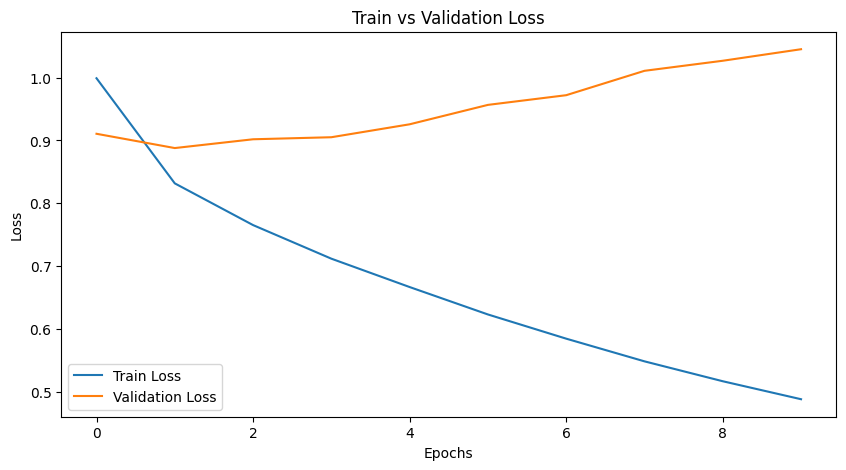

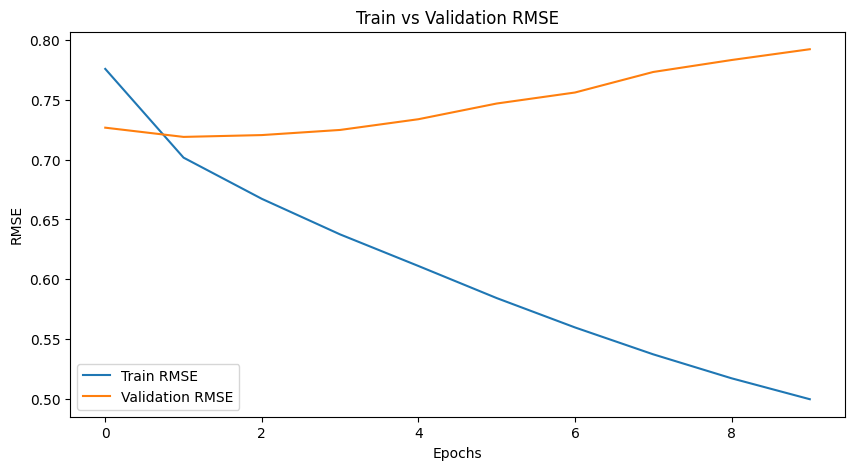

In [8]:
import matplotlib.pyplot as plt

# Plotting the losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Test Loss')
plt.show()

# Plotting the RMSE
plt.figure(figsize=(10,5))
plt.plot(train_rmse_list, label='Train RMSE')
plt.plot(valid_rmse_list, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Train vs Validation RMSE')
plt.show()


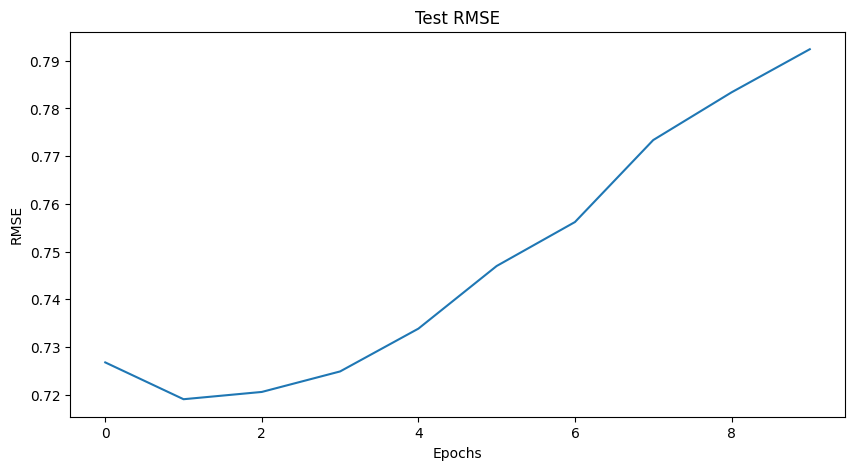

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# Plot the losses vs. epochs for training and test sets
epochs = range(1, n_epochs + 1)
# Plot the RMSE
plt.figure(figsize=(10,5))
plt.plot(np.arange(n_epochs), valid_rmse_list)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Test RMSE')
plt.show()